In [1]:
import numpy as np
import pandas as pd


from NPIR import NPIR

from sklearn.utils import shuffle
from sklearn.datasets import make_blobs, make_moons
from sklearn import metrics

import matplotlib.pyplot as plt

# ### multiprocessing
# from multiprocessing.pool import Pool
# import multiprocessing


import datetime
# import warnings
from collections import Counter as Cs
from timeit import default_timer as timer
from datetime import timedelta


import findspark
findspark.init()

########
from pyspark.mllib.clustering import KMeans
########
from operator import *

from pyspark import SparkContext
# from pyspark import StorageLevel
from pyspark.sql.types import IntegerType, FloatType, BooleanType, StringType, StructType,\
                StructField,ArrayType, DataType
from pyspark.sql.types import *

from pyspark.sql.functions import udf, log, rand, monotonically_increasing_id, col, broadcast,\
                greatest, desc, asc, row_number, avg, mean, least, struct, lit, sequence, sum, \
                monotonically_increasing_id, pandas_udf, PandasUDFType
import pyspark.sql.functions as F

from functools import reduce
from pyspark.sql import SparkSession, SQLContext, Window, Row, DataFrame
from pyspark import SparkConf
from scipy.spatial import distance
from pyspark.sql.window import Window

In [2]:
# config("spark.sql.broadcastTimeout", "300000s").\
# config("spark.network.timeout","300000s").config("spark.executor.heartbeatInterval","12000000ms").\
spark = SparkSession.builder.master("local[*]").\
config("spark.storage.blockManagerSlaveTimeoutMs","12000001ms").config("spark.driver.maxResultSize","24g").\
config("spark.default.parallelism", "200").config("spark.memory.offHeap.enabled","true").\
config("spark.memory.offHeap.size", "24g").config("spark.executor.memory", "24g").\
config("spark.driver.memory", "24g").appName("NPIR_Parallel").getOrCreate()

# spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
# spark.conf.set('spark.jars.packages','com.databricks:spark-cav_2.11')
# spark.conf.set("spark.sql.parquet.compression.codec","gzip")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "True")


In [3]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [32]:
x1,y1 = make_blobs(n_samples=5000, centers=3, n_features=3,
                random_state=1)
data = pd.DataFrame(x1)
data['label'] = y1

data = shuffle(data)

data.to_csv('blobs3.csv', index=False)

In [5]:
# # make_moons
# x1,y1 = make_moons(n_samples=5000000, random_state=1)
# data = pd.DataFrame(x1)
# data['label'] = y1


# data = shuffle(data)

# data.to_csv('moons1.csv', index=False)
# del data

In [7]:
#read csv
data_spark_df = spark.read.format('csv').option('header','True').option('index','False').load('blobs3.csv')
# data_spark_df.show()
# data_spark_df.count()

In [8]:
data_spark_df.describe()

DataFrame[summary: string, 0: string, 1: string, 2: string, label: string]

In [9]:
data_spark_df.printSchema()

root
 |-- 0: string (nullable = true)
 |-- 1: string (nullable = true)
 |-- 2: string (nullable = true)
 |-- label: string (nullable = true)



In [10]:
data_spark_df = data_spark_df.select(data_spark_df.columns[:-1])

In [11]:
points = data_spark_df.count()
points

5000

In [12]:
#IR: The indexing ratio to be used for generating the maximum index
IR = 0.2
i = 10#The number of iteration i
k = 3 #k: Number of clusters
chunk = 200

In [13]:
start = timer()
# setup the spark data frame as a table

# add train/test label and expand the data set by 3x (each num trees parameter)
# data_spark_df.createOrReplaceTempView("data_spark_df")
df2 = data_spark_df.selectExpr(
    "*",
    "int(rand() * " + str(int(points / chunk)) + ") chunks",
#     "case when rand() < 0.8 then 1 else 0 end training"
)
results = df2.orderBy(F.col("chunks"))
# df2.show()

In [14]:
# results.printSchema()

In [15]:
start = timer()
dim = len(data_spark_df.columns)
structList = []
for i in range(dim):
    structList.append(StructField('P' + str(i),
            ArrayType(StringType()),
            True))
schema = StructType(structList)
# schema = StructType([StructField('label',
#             ArrayType(StringType()),
#             True)])  

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def apply_NPIR(data):
    data = pd.DataFrame(data.astype(float).values[:,:-1])
    from NPIR import NPIR
#     label = [str(x) for x in NPIR(data.values,k,IR,i)]
#     label = (np.vstack(label).tolist())
    label = NPIR(data.values,k,IR,i)
    del NPIR
    data['labels'] = label
    leader = []
    f = list(Cs(label))
    f.sort()
    for ii in f:
        leader.append([round(np.mean(z), 10) for z in data[data['labels']==ii].values[:, :-1].T])
    del data
    cols = ['P'+str(i) for i in range(dim)]
    leader = pd.DataFrame(leader, columns=cols)
    for col in cols:
        leader[col] = leader[col].map(str)
#     return pd.DataFrame(label, columns=['label'])
    return leader


# use the Pandas UDF
# results = df2.groupby('chunks').apply(runner)
results = results.groupby('chunks').apply(apply_NPIR)

for c in results.columns:
    results = results.withColumn(c, F.array_join(c, ""))
results = results.select(*(col(c).cast("float").alias(c) for c in results.columns))

# del data_spark
# results.show()


/opt/spark/python/pyspark/sql/pandas/group_ops.py:76: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  "more details.", UserWarning)


In [16]:
# for c in results.columns:
#     results = results.withColumn(c, F.array_join(c, ""))
# results = results.select(*(col(c).cast("float").alias(c) for c in results.columns))
# print(results.count())
end = timer()
print ("Execution time HH:MM:SS:", timedelta(seconds= end - start))

Execution time HH:MM:SS: 0:00:01.060372


## topandas action: 400000/200 = 2000 => 1
## NPIR calculation: 400000/200 = 2000 => 400000/200/4 = 500


## 1e7/200 = 50000
## 1e7/200/200/200

## np.floor(np.log(1E10)/np.log(200)) + 1

In [17]:
start = timer()
# leaders_spark_df = leaders_spark_df.select('1', '2')
# Build the model (cluster the data)
results = results.rdd.map(list)
clusters = KMeans.train(results, k, maxIterations=20, initializationMode="random")
# del parsedData
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

Execution time HH:MM:SS: 0:00:20.437545


In [18]:
# results = results.rdd.map(list)
# centers = results.collect()
# end = timer()
# print ("Execution time HH:MM:SS:", timedelta(seconds= end - start))

In [19]:
dataCol = data_spark_df.columns

In [20]:
start = timer()
############ Updateing points clusters
for i in range(k):
    if i == 0:
        centerOfiTH = clusters.centers[i].tolist()#for example, the entry against which you want distances
        distance_udf = F.udf(lambda x: float(distance.euclidean([float(z) for z in x], centerOfiTH)),\
                             FloatType())
        columns = [F.col(c) for c in dataCol]
        data_cent = data_spark_df.withColumn('dis' + str(i) + 'th', distance_udf(F.array(columns)))
        del data_spark_df
        data_cent = data_cent.withColumn('mindist', col('dis' + str(i) + 'th'))
        data_cent
        data_cent = data_cent.withColumn('mindist1', least(col('dis' + str(i) + 'th'), col('mindist')))
        data_cent = data_cent.drop('mindist')
    #     .drop('dis' + str(i) + 'th')
        data_cent = data_cent.withColumnRenamed('mindist1', 'mindist')
    elif i > 0:
        centerOfiTH = clusters.centers[i].tolist()#for example, the entry against which you want distances
        distance_udf = F.udf(lambda x: float(distance.euclidean([float(z) for z in x], centerOfiTH)),\
                             FloatType())
        columns = [F.col(c) for c in dataCol]
        data_cent = data_cent.withColumn('dis' + str(i) + 'th', distance_udf(F.array(columns)))
        data_cent = data_cent.withColumn('mindist1', least(col('dis' + str(i) + 'th'), col('mindist')))#4
        data_cent = data_cent.drop('mindist')
    #     .drop('dis' + str(i) + 'th')
        data_cent = data_cent.withColumnRenamed('mindist1', 'mindist')
data_cent = data_cent.drop('mindist')

# data_cent.show()

In [21]:
def Min_COl( *row_list):
    ind = row_list.index(min(*row_list))
    return int(ind)

find_min_val_name = udf(Min_COl, IntegerType())
data_cent = data_cent.withColumn('defined_cluster', find_min_val_name(*data_cent.\
            columns[len(dataCol):len(dataCol) + 1 + k]))
# data_cent.show()

In [22]:
# for c in range(k):
#     data_cent = data_cent.drop('dis' + str(c) + 'th')
# # data_cent.show()

In [33]:
d = data_cent.select('defined_cluster').toPandas()

end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

Execution time HH:MM:SS: 0:03:22.033410


In [34]:
data = pd.read_csv('blobs3.csv')
data.head()

,0,1,2,label
0,-3.226393,-8.238970,-7.055899,1
1,-0.941970,4.155785,-10.049242,0
2,-6.898729,-2.182606,-2.569238,2
3,-6.593300,-2.925185,-2.303824,2
4,-2.231090,-7.187570,-8.615956,1


In [35]:
# data = data[['0','1','label']]

In [36]:
# data['new'] = d['defined_cluster'].astype('int8')
# data.head()

In [37]:
y = data['label']
labelsPred = d['defined_cluster'].astype('int8')
x = data[['0','1']].values
x.shape

(5000, 2)

In [38]:
del data
del d

In [39]:
#printing results
#print('labels:')
# print(labelsPred)

# tEnd = datetime.datetime.now()
# print('Time: ' + str(tEnd - tStart))
print('Measures:')
print('HS: ' + str(metrics.homogeneity_score(y,labelsPred)))
print('CS: ' + str(metrics.completeness_score(y,labelsPred)))
print('VM: ' + str(metrics.v_measure_score(y,labelsPred)))
print('AMI: ' + str(metrics.adjusted_mutual_info_score(y,labelsPred)))
print('ARI: ' + str(metrics.adjusted_rand_score(y,labelsPred)))

Measures:
HS: 0.5794222382650986
CS: 0.7342591149758677
VM: 0.6477157627551844
AMI: 0.6475722009166964
ARI: 0.4448794177966249


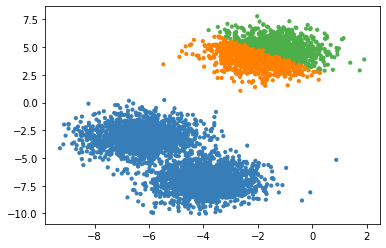

In [40]:
import matplotlib.pyplot as plt
from itertools import cycle, islice 

fig = plt.figure()      
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),int(k))))
plt.scatter(x[:, 0], x[:, 1], s=10, color=colors[labelsPred.tolist()])
plt.show()
# plt.clf()